* Input-to-hidden weight matrix: W (DxM)
* Hidden bias: b(M)
* Hidden-to-ouput weight matrix: V (MxK) 
* Output bias: c(K)

<img src="images/one_hidden_layer.png" alt="Drawing" style="width:30%;height:30%"/>

### Prediction
* Feedforward

```
Z1 = s(W_0 * X)
Z2 = s(W_1 * Z1)
Z3 = s(W_2 * Z2)
y = s(W_3 * Z3)
```

* s( ) is nonlinearity such as sigmoid, tanh, relu or softmax
* Last layer is sigmoid for binary, softmax for more than 2 classes

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
XW = np.arange(12).reshape(3,4)
b = np.arange(4)

print(XW.shape)
print(b.shape)
print(XW)
print(b)
Y = np.add(XW,b)
print(Y)
print(Y.shape)

(3, 4)
(4,)
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[0 1 2 3]
[[ 0  2  4  6]
 [ 4  6  8 10]
 [ 8 10 12 14]]
(3, 4)


In [46]:
def sigmoid(A):
    return 1/(1+np.exp(-A))

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)


In [47]:
A = np.arange(9).reshape(3,3)
print(A)
A = softmax(A)
A.sum(axis=1)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


array([ 1.,  1.,  1.])

In [56]:
N=50
D=2 # dimensionality of input
M=4 # hidden layer size
K=3 # number of classes

# input
X=np.random.randn(N, D)
print(X.shape)

# enter the hidden layer
ones1 = np.ones((N,1))
X = np.concatenate((X, ones1), axis=1)
W1= np.random.randn(D+1,M)
I1 = X.dot(W1)

Z = sigmoid(I1)
print(Z.shape)
# enter the outer layer
ones2 = np.ones((N,1))
Z = np.concatenate((Z, ones2), axis=1)
W2= np.random.randn(M+1,K)
I2= Z.dot(W2)

P = softmax(I2)
print(P.shape)

# print(P.shape)
# print(P.sum(axis=1, keepdims=True))
print(P[0:5,:])

(50, 2)
(50, 4)
(50, 3)
[[ 0.31937312  0.46055521  0.22007167]
 [ 0.36309794  0.34154628  0.29535578]
 [ 0.30066031  0.56799514  0.13134455]
 [ 0.31136977  0.48722925  0.20140099]
 [ 0.31900617  0.52547146  0.15552237]]


### Train
* The training is an application of gradient descent
* W <- W - learning_rate * derivative of loss function w.r.t. W
* Thena and TensorFlow will calculate the derivative for us

In [68]:
def fit(X, Y, hidden_num):
    
    N, D = X.shape
    K = len(set(Y))
    M = hidden_num
    
    # one-hot-encoding on the target/class label
    T = np.zeros((N, K))
    for i in range(N):
        T[i, Y[i]] = 1
    
    # randomly initialize weights and bias
    # W1 is the weight matrix for first layer (hidden layer)
    # W2 is the weight matrix for second layer (out payer)
    W1 = np.random.randn(D, M)
    b1 = np.random.randn(M)
    W2 = np.random.randn(M, K)
    b2 = np.random.randn(K)

    learning_rate = 10e-7
    costs = []
    epochs = 10000
    for e in range(epochs + 1):
        output, hidden = forward(X, W1, b1, W2, b2)
        if e % 100 == 0:
            # probably 'cost' is not a good name since we are using gradient ascent here
            c = cost(T, output) 
            P = np.argmax(output, axis=1)
            r = classification_rate(Y, P)
            print(e, "cost: ", c, "classification rate: ", r)
            costs.append(c)

        W2 += learning_rate * derivative_W2(T, output, hidden)
        b2 += learning_rate * derivative_b2(T, output);
        W1 += learning_rate * derivative_W1(T, output, W2, hidden, X)
        b1 += learning_rate * derivative_b1(T, output, W2, hidden)
    

In [60]:
# softmax(sigmoid(X*W1 + b1)*W2 + b2)
def forward(X, W1, b1, W2, b2):
    Z = sigmoid(X.dot(W1) + b1)
    Y = softmax(Z.dot(W2) + b2)  
    return Y, Z

In [61]:

def derivative_W2(T, Y, Z):
    N, K = T.shape
    M = Z.shape[1]
    
    ret1 = np.zeros((M, K))
    for n in range(N):
        for m in range(M):
            for k in range(K):
                ret1[m, k] += (T[n, k] - Y[n, k]) * Z[n, m]
                
    return ret1


def derivative_b2(T, Y):
    N, K = T.shape
    
    ret1 = np.zeros(K)
    for n in range(N):
            for k in range(K):
                ret1[k] += T[n, k] - Y[n, k]
    return ret1
    
    
def derivative_W1(T, Y, W2, Z, X):
    N, K = T.shape
    M = Z.shape[1]
    D = X.shape[1]
    
    ret1 = np.zeros((D, M))
    for n in range(N):
        for d in range(D):
            for m in range(M):
                for k in range(K):
                    ret1[d, m] += (T[n, k] - Y[n, k]) * W2[m, k] * Z[n, m] * (1 - Z[n, m]) * X[n, d]
    
    return ret1

def derivative_b1(T, Y, W2, Z):
    N, K = T.shape
    M = Z.shape[1]
    
    ret1 = np.zeros(M)
    for n in range(N):
        for m in range(M):
            for k in range(K):
                ret1[m] += (T[n, k] - Y[n, k]) * W2[m, k] * Z[n, m] * (1 - Z[n, m])
    
    return ret1

In [62]:
def classification_rate(Y, T):
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i] == T[i]:
            n_correct += 1
    return float(n_correct/n_total)


def cost(T, Y):
    tot = T * np.log(Y)
    return tot.sum()

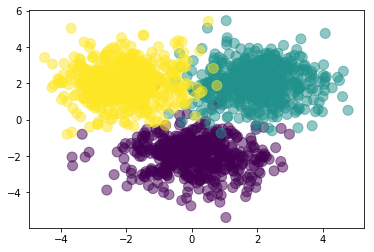

In [63]:
Nclass = 500 # number of samples for each classes
D = 2 # dimensionality of input
M = 3 # hidden layer size
K = 3 # number of classes

X1 = np.random.randn(Nclass, D) + np.array([0, -2])
X2 = np.random.randn(Nclass, D) + np.array([2, 2])
X3 = np.random.randn(Nclass, D) + np.array([-2, 2])
X = np.vstack([X1, X2, X3])

Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)
N = len(Y)

plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, alpha=0.5)
plt.show()

In [64]:
fit(X, Y, M)

0 cost:  -2530.11476537 classification rate:  0.30733333333333335
100 cost:  -2440.16513969 classification rate:  0.328
200 cost:  -2356.55959168 classification rate:  0.352
300 cost:  -2279.0366912 classification rate:  0.37866666666666665
400 cost:  -2207.29847285 classification rate:  0.4106666666666667
500 cost:  -2141.0110723 classification rate:  0.434
600 cost:  -2079.81023027 classification rate:  0.438
700 cost:  -2023.31028773 classification rate:  0.44466666666666665
800 cost:  -1971.1150904 classification rate:  0.452
900 cost:  -1922.82926668 classification rate:  0.454
1000 cost:  -1878.06859445 classification rate:  0.46266666666666667
1100 cost:  -1836.46855301 classification rate:  0.4573333333333333
1200 cost:  -1797.69057846 classification rate:  0.458
1300 cost:  -1761.42592816 classification rate:  0.46
1400 cost:  -1727.39735812 classification rate:  0.466
1500 cost:  -1695.35900484 classification rate:  0.468
1600 cost:  -1665.09494184 classification rate:  0.48


KeyboardInterrupt: 

In [66]:

def derivative_W2(T, Y, Z):
#     N, K = T.shape
#     M = Z.shape[1]
#     ret1 = np.zeros((M, K))
#     for n in range(N):
#         for m in range(M):
#             for k in range(K):
#                 ret1[m, k] += (T[n, k] - Y[n, k]) * Z[n, m]
#     return ret1

    return Z.T.dot(T-Y)


def derivative_b2(T, Y):
#     N, K = T.shape
#     ret1 = np.zeros(K)
#     for n in range(N):
#             for k in range(K):
#                 ret1[k] += T[n, k] - Y[n, k]
#     return ret1

    return (T - Y).sum(axis=0)
    
    
def derivative_W1(T, Y, W2, Z, X):
#     N, K = T.shape
#     M = Z.shape[1]
#     D = X.shape[1]
#     ret1 = np.zeros((D, M))
#     for n in range(N):
#         for d in range(D):
#             for m in range(M):
#                 for k in range(K):
#                     ret1[d, m] += (T[n, k] - Y[n, k]) * W2[m, k] * Z[n, m] * (1 - Z[n, m]) * X[n, d]
#     return ret1

    dA = (T - Y).dot(W2.T) * Z * (1 - Z)
    return X.T.dot(dA)

def derivative_b1(T, Y, W2, Z):
#     N, K = T.shape
#     M = Z.shape[1]
#     ret1 = np.zeros(M)
#     for n in range(N):
#         for m in range(M):
#             for k in range(K):
#                 ret1[m] += (T[n, k] - Y[n, k]) * W2[m, k] * Z[n, m] * (1 - Z[n, m])
#     return ret1

    dz = (T - Y).dot(W2.T) * Z * (1 - Z)
    return dz.sum(axis=0)

In [69]:
fit(X, Y, M)

0 cost:  -1607.10308608 classification rate:  0.3333333333333333
100 cost:  -1542.00793155 classification rate:  0.36
200 cost:  -1484.28154125 classification rate:  0.43133333333333335
300 cost:  -1432.9236673 classification rate:  0.47733333333333333
400 cost:  -1387.02095501 classification rate:  0.5093333333333333
500 cost:  -1345.76500016 classification rate:  0.534
600 cost:  -1308.45856972 classification rate:  0.552
700 cost:  -1274.51300618 classification rate:  0.5706666666666667
800 cost:  -1243.43968912 classification rate:  0.584
900 cost:  -1214.83802043 classification rate:  0.5966666666666667
1000 cost:  -1188.38191321 classification rate:  0.604
1100 cost:  -1163.80628199 classification rate:  0.618
1200 cost:  -1140.89457874 classification rate:  0.6313333333333333
1300 cost:  -1119.46800453 classification rate:  0.6473333333333333
1400 cost:  -1099.37666811 classification rate:  0.674
1500 cost:  -1080.49268091 classification rate:  0.7193333333333334
1600 cost:  -10

## Question

** Question 1 **
* Suppose we removed all the nonlinearities from this neural network. What is the result?
<img src="images/one_hidden_sigmoid.png" alt="Drawing" style="width:30%;height:30%"/>
    * Option 1) You get a neural network for regression, since the output can now take on any value
    * Option 2) Linear Regression
    * Option 3) Does not change anything, this is still a nonlinear function approcimator
* Answer
    * If we remove the nonlinearities, this is exactly the same from as linear regression. Multiplying 2 matrices together just gives you another matrix
<img src="images/nonlinearities.png" alt="Drawing" style="width:40%;height:40%"/>

** Question 2 **

* What is the output?
    * input: X = [[1,2]]
    * input-to-hidden: W1 = [[1,1], [1,0]]
    * hidden-to-output: W2 = [[0,1], [1,1]]
    * hidden layer nonlinearity: tanh()
    * no bias terms
    * softmax at output


In [70]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

X = np.array([[1,2]])

W1 = np.array([[1,1], [1,0]])
W2 = np.array([[0,1], [1,1]])

Z = X.dot(W1)
Z = np.tanh(Z)

Y = Z.dot(W2)
print(softmax(Y))

[[ 0.26991483  0.73008517]]


<img src="images/one_hidden_softmax.png" alt="Drawing" style="width:30%;height:30%"/>